# Download dataset and unzip content

In [1]:
%%bash
kaggle datasets download -d sebastienverpile/consumercomplaintsdata
unzip consumercomplaintsdata.zip
rm consumercomplaintsdata.zip

100%|██████████| 107M/107M [00:01<00:00, 89.8MB/s] 



Archive:  consumercomplaintsdata.zip
  inflating: Consumer_Complaints.csv  


# Imports

In [5]:
import pandas as pd
import spacy
from collections import Counter
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from bertopic import BERTopic
plt.style.use('ggplot')
import numpy as np
tqdm.pandas()
# if necessary install the spacy's large english model with:
# python -m spacy download en_core_web_lg

# reading input dataset

In [2]:
df = pd.read_csv('Consumer_Complaints.csv')

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


In [4]:
# filtering only relevant columns for topic identification
df = df[['Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()
# filtering rows where consumer complaint is not available
ftr = ~df['Consumer complaint narrative'].isna()
df = df[ftr]
# sanity check
df['Consumer complaint narrative'].isna().sum()

0

In [5]:
# Checking for duplicate comments
df.duplicated(subset=['Consumer complaint narrative']).sum()

4653

In [6]:
# removing duplicates
df = df.drop_duplicates(subset=['Consumer complaint narrative'])
df.shape

(195317, 3)

# Processing complaints

In [7]:
df = df.reset_index()
df = df.drop(columns=['index'])
df.head()

,Issue,Sub-issue,Consumer complaint narrative
0,Incorrect information on credit report,Account status,I have outdated information on my credit repor...
1,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...
2,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...
3,Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...
4,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...


In [8]:
# using better naming convention for columns
df.columns = ['issue', 'sub_issue', 'complaint']

### loading spacy's language model

In [2]:
nlp = spacy.load('en_core_web_lg')

The first thing to be done is to process the complaint texts. <br>
I will remove stopwords, remove non-alpha numeric tokens, lemmatize the tokens, and normalize the tokens returning its lowercase version. 

In [11]:
def preprocess_text(text):
    '''
    Function that will tokenize the input text, remove stopwords, remove non alpha-numeric tokens and return the lowered version of a token
    '''
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

In [12]:
df['processed_complaint'] = df['complaint'].progress_apply(preprocess_text)

100%|██████████| 195317/195317 [1:06:28<00:00, 48.97it/s] 


In [3]:
df.head()

,issue,sub_issue,complaint,processed_complaint
0,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,outdated information credit report previously ...
1,Managing the loan or lease,None,I purchased a new car on XXXX XXXX. The car de...,purchase new car xxxx xxxx car dealer call cit...
2,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,account credit report mistaken date mail debt ...
3,Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,company refuse provide verification validation...
4,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,complaint regard square financial refer cfpb c...


### Next let's identify potential domain specific stop words by looking at the most common tokens in the processed texts

In [6]:
tokens = []
for idx in tqdm(range(df.shape[0])):
    doc = nlp(df.loc[idx, 'processed_complaint'], disable=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"])
    tokens += [token.text for token in doc]
# docs = list(nlp.pipe(df['complaint'], disable=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"], n_process=-1))
# tokens = [token.text for doc in tqdm(docs) for text in doc]

100%|██████████| 195317/195317 [09:39<00:00, 336.96it/s]


In [7]:
len(tokens)

16542256

In [8]:
c = Counter(tokens)
c.most_common(100)

[('xxxx', 1828545),
 ('account', 271706),
 ('credit', 270927),
 ('xx', 259410),
 ('payment', 210930),
 ('report', 174190),
 ('loan', 173047),
 ('pay', 165920),
 ('tell', 130121),
 ('call', 128476),
 ('receive', 127511),
 ('time', 122836),
 ('bank', 121477),
 ('debt', 110116),
 ('send', 108640),
 ('information', 101904),
 ('company', 95993),
 ('card', 93094),
 ('say', 85335),
 ('day', 84329),
 ('mortgage', 82721),
 ('state', 81831),
 ('letter', 81794),
 ('month', 81328),
 ('request', 78483),
 ('ask', 78293),
 ('charge', 77095),
 ('year', 75966),
 ('contact', 74480),
 ('file', 63913),
 ('number', 63713),
 ('dispute', 61310),
 ('collection', 59523),
 ('go', 59228),
 ('phone', 59143),
 ('check', 58429),
 ('fee', 57507),
 ('date', 57041),
 ('money', 56968),
 ('provide', 56306),
 ('try', 53689),
 ('balance', 53387),
 ('need', 52850),
 ('remove', 51090),
 ('home', 50979),
 ('service', 48492),
 ('interest', 46649),
 ('late', 46333),
 ('know', 45735),
 ('issue', 44796),
 ('want', 42613),
 ('spe

In [5]:
# removing additional stop words

def remove_stopwords(sentence: str):
    '''
    remove domain specific stop words from a function
    '''
    
    additional_stopwords = ['xxxx', 'account', 'credit', 'xx']
    
    for w in additional_stopwords:
        sentence = sentence.replace(w, '')
        
    return sentence

df['processed_complaint'] = df['processed_complaint'].progress_apply(remove_stopwords)

100%|██████████| 195317/195317 [00:00<00:00, 307474.31it/s]


In [80]:
df.head()

,issue,sub_issue,complaint,processed_complaint
0,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,outdated information report previously disput...
1,Managing the loan or lease,None,I purchased a new car on XXXX XXXX. The car de...,purchase new car car dealer call citizens ba...
2,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,report mistaken date mail debt validation le...
3,Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,company refuse provide verification validation...
4,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,complaint regard square financial refer cfpb c...


# approach 1 - TF-IDF vectorization + Latent Dirichlet Allocation
## The first stratgy to extract the topics from documents will be to generate a TF-IDF matrix: 
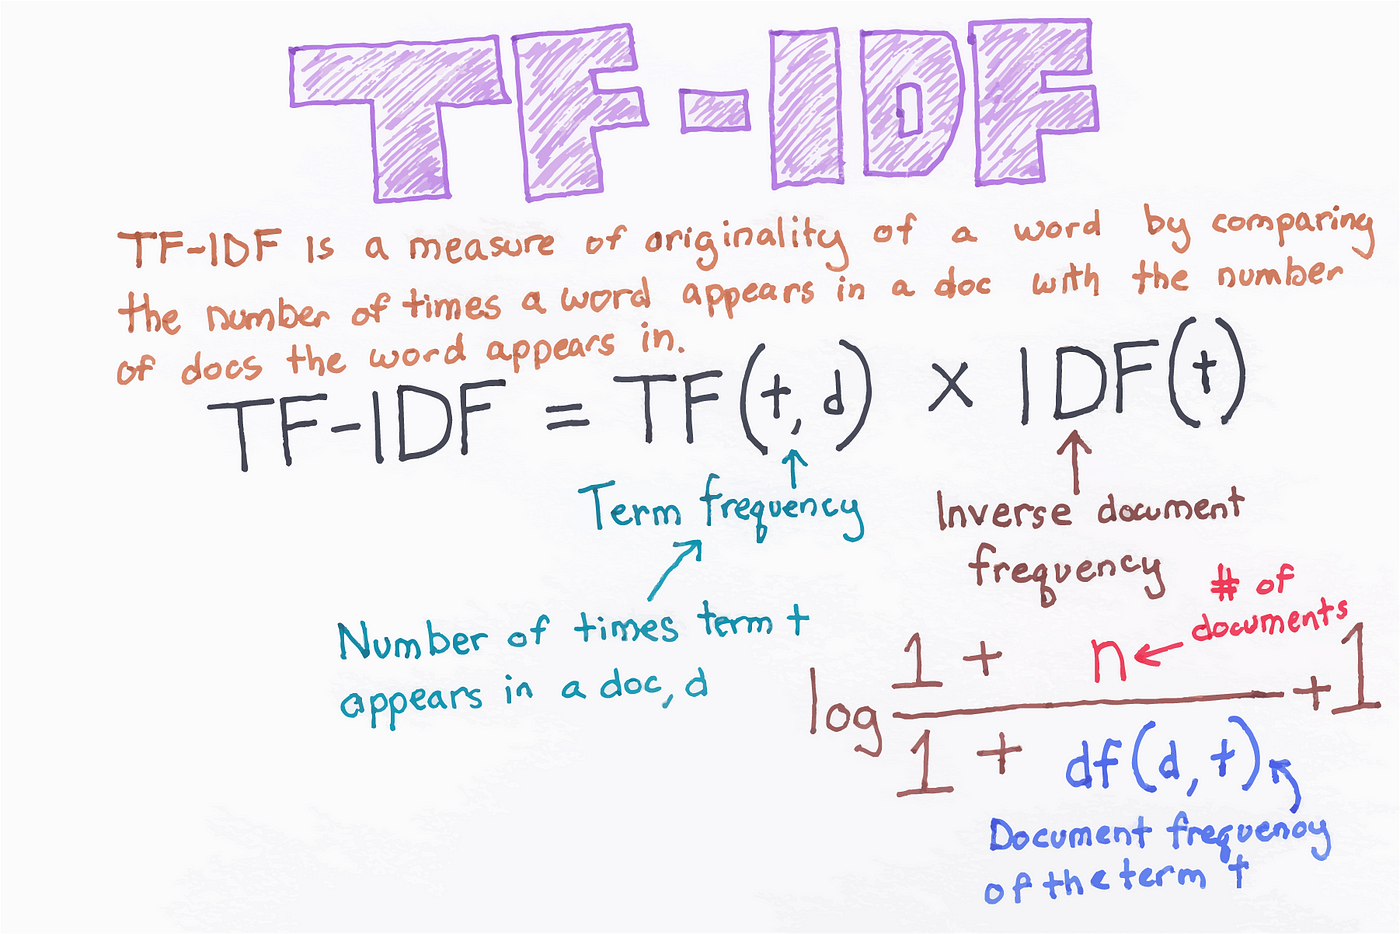

## then perform semantic analysis using LDA:
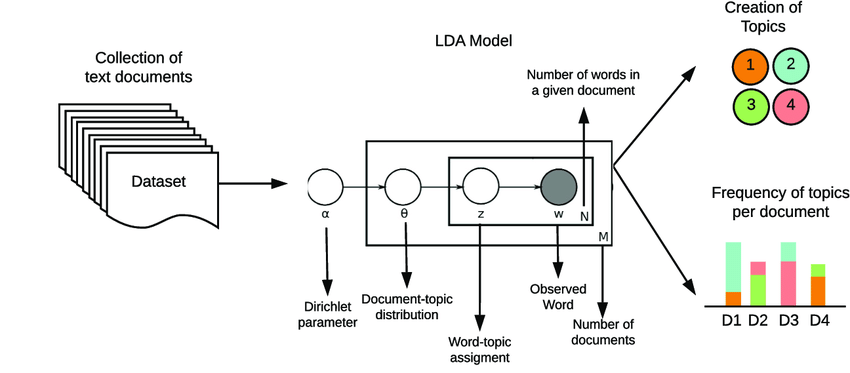

In [8]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3))
tfidf_matrix = tfidf_vec.fit_transform(df['processed_complaint'])

In [10]:
tfidf_matrix.shape

(195317, 11147762)

As we can see, the size of this matrix is huge. In order to not run out of memory in the next steps, <br>
I will sample 5% of the complaints and perform tfidf vectorization again. 

In [81]:
# considering only unigrams, so fitting process does not take so long. ngram_range is the parameter we 
# would have to tweak if we would like to include, bigrams, trigrams, etc.
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
sample_df = df['processed_complaint'].sample(frac=0.1, random_state=1996)
tfidf_matrix = tfidf_vec.fit_transform(sample_df)

In [82]:
tfidf_matrix.shape

(19532, 21585)

### chosing the best number of topics

In [83]:
# now lets split the matrix into train and validation.
# The validation data is going to be used to calculate the perplexity and fine tune the number of topics
train_matrix, val_matrix = tfidf_matrix[:tfidf_matrix.shape[0] // 2, :], tfidf_matrix[tfidf_matrix.shape[0] // 2:, :]
train_matrix.shape, val_matrix.shape

((9766, 21585), (9766, 21585))

In [56]:
topic_numbers = list(range(5, 51, 5))
best_perplexity, best_num = float('inf'), 0 
perplexities = []
for n in tqdm(topic_numbers):
    lda_model = LatentDirichletAllocation(n_components=n, learning_method='online', verbose=0, random_state=1996, n_jobs=-1)
    lda_model.fit(train_matrix)
    perp = lda_model.perplexity(val_matrix)
    # appending perplexity values, so we can latter plot the results
    perplexities.append(perp)
    
    if perp < best_perplexity:
        best_perplexity, best_num = perp, n
print(f"best (lowest) perplexity score found with {best_num} topics")

100%|██████████| 10/10 [08:04<00:00, 48.42s/it]

best (lowest) perplexity score found with 5 topics


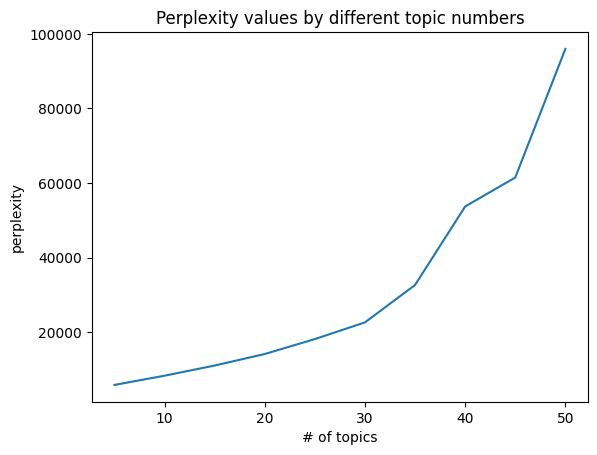

In [62]:
plt.title('Perplexity values by different topic numbers')
plt.xlabel('# of topics')
plt.ylabel('perplexity')
plt.plot(topic_numbers, perplexities)
plt.show()

Let's now take a look at the score metric:

In [85]:
topic_numbers = list(range(5, 51, 5))
best_score, best_num = float('-inf'), 0 
scores = []
for n in tqdm(topic_numbers):
    lda_model = LatentDirichletAllocation(n_components=n, learning_method='online', verbose=0, random_state=1996, n_jobs=-1)
    lda_model.fit(train_matrix)
    score = lda_model.score(val_matrix)
    # appending score values, so we can latter plot the results
    scores.append(score)
    
    if score > best_score:
        best_score, best_num = score, n
print(f"best score found with {best_num} topics")

100%|██████████| 10/10 [07:54<00:00, 47.48s/it]

best score found with 0 topics


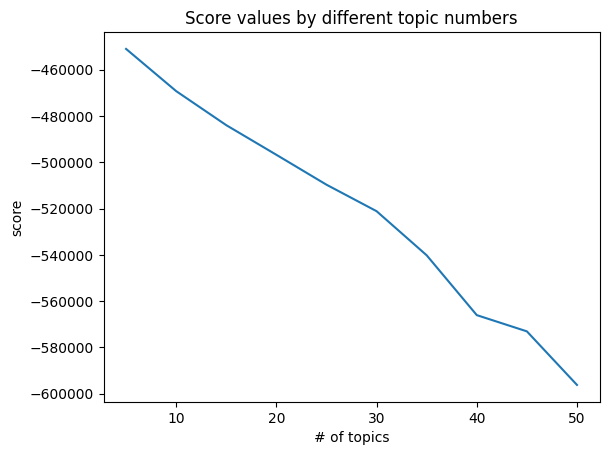

In [87]:
plt.title('Score values by different topic numbers')
plt.xlabel('# of topics')
plt.ylabel('score')
plt.plot(topic_numbers, scores)
plt.show()

Unfortunnately the perplexity curve is monotonically increasing as the number of topics grow. <br>
the score curve is monotonically decreasing as the number of topics grow <br>
As such this experiment didn't reveal a certain number of topics  that is associated with a minimum perplexity, or maximum score that could be picked. <br>
I will use the default value of 10 in the next steps.

In [95]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', verbose=0, random_state=1996, n_jobs=-1)

In [96]:
lda_matrix = lda_model.fit_transform(tfidf_matrix)

## Analyzing the results

In [97]:
lda_matrix.shape

(19532, 10)

The resulting matrix has dimensions (num_documents, num_topics)

## explaining each topic

In [98]:
topic_components = pd.DataFrame(lda_model.components_, columns=tfidf_vec.get_feature_names_out())
topic_components

,aa,aaa,aaadvantage,aadvantage,aadvantgae,aadvatage,aafe,aafes,aag,aaii,...,zion,zions,zip,zombie,zone,zoned,zoning,zoom,zwicker,zwickers
0,0.100000,0.100000,0.100001,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001
1,0.100000,0.100000,0.100001,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001
2,1.483701,1.130293,0.175686,5.062562,0.253997,0.100044,0.805827,1.497783,0.883046,0.101013,...,1.380113,1.730548,5.910323,2.778275,3.084395,0.266353,0.263439,0.318845,1.936304,0.165415
3,0.100064,0.100000,0.100000,0.100000,0.100000,0.258129,0.100000,0.100000,0.100000,0.166140,...,0.100000,0.100000,0.100000,0.100000,0.100023,0.100000,0.100000,0.100000,0.100000,0.100001
4,0.100024,0.100000,0.100001,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001
5,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100014,0.100009,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001
6,0.100000,0.100000,0.100001,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001
7,0.100000,0.100000,0.100001,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001
8,0.100000,0.100000,0.100001,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001
9,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100001


In [99]:
for topic in range(10):
    print(f'Topic {topic} top 20 most important words:')
    print(topic_components.iloc[topic,:].sort_values(ascending=False)[:20], '\n\n')

Topic 0 top 20 most important words:
knowlegde     1.292145
fasfa         1.170679
inq           1.148162
evergreen     1.096196
sorority      0.983767
tidewater     0.968589
wount         0.886637
collet        0.885300
colloctors    0.885300
ital          0.697059
uto           0.697059
garnishee     0.665262
abalance      0.663224
naviemt       0.656009
apiece        0.590306
mortgue       0.493310
escrol        0.493310
garnisheed    0.476836
timothy       0.476836
baxter        0.476836
Name: 0, dtype: float64 


Topic 1 top 20 most important words:
compass        8.767358
bbva           7.970308
nissan         4.561750
sol            2.814153
od             2.528101
capone         2.449738
deutsche       2.347768
divulge        2.162205
languish       2.002716
schwab         1.955282
abd            1.627091
tfs            1.619193
loanme         1.606457
accoutnt       1.472464
incessantly    1.417265
meridian       1.269096
nmac           1.215010
distant        1.147243
verfie 

### Taking a look at the most important words for the topics, it is possible to extract insights like:
- Topic two is heavily related to complaints about payments, loans and different types of debts like mortgages
- Topic 1 is more strongly associated with complaints regarding nissan and eurpean banks like BBVA and Deutsche Bank
- Different topics are more strongly related to certain companies: Paypal is heavily linked with topic 9, and nelnet with topic 6

We can also take a look at the percentage of the topic that is present in a document. <br>
To help us to even further make sense of the topics meaning, lets try to filter complaints that belong to a specific topic, and interpret them:

In [103]:
# Converting lda_matrix from numpy to pandas DataFrame
lda_matrix = pd.DataFrame(lda_matrix)

In [106]:
lda_matrix['strongest_topic'] = lda_matrix.progress_apply(np.argmax, axis=1)

100%|██████████| 19532/19532 [00:00<00:00, 21162.65it/s]


In [109]:
lda_matrix['topic_percentage'] = lda_matrix.progress_apply(lambda cols: cols[cols['strongest_topic']], axis=1)

100%|██████████| 19532/19532 [00:00<00:00, 187598.94it/s]


In [110]:
lda_matrix.head()

,0,1,2,3,4,5,6,7,8,9,strongest_topic,topic_percentage
0,0.015877,0.015877,0.857109,0.015877,0.015877,0.015877,0.015877,0.015877,0.015877,0.015877,2,0.857109
1,0.014222,0.014222,0.872002,0.014222,0.014222,0.014222,0.014222,0.014222,0.014222,0.014222,2,0.872002
2,0.015963,0.015963,0.856334,0.015963,0.015963,0.015963,0.015963,0.015963,0.015963,0.015963,2,0.856334
3,0.016850,0.016850,0.811307,0.016850,0.016850,0.053889,0.016850,0.016850,0.016850,0.016850,2,0.811307
4,0.012489,0.012489,0.887598,0.012489,0.012489,0.012489,0.012489,0.012489,0.012489,0.012489,2,0.887598


#### retrieving original_complaints and concatenating topic information

In [114]:
orig_complaints = df.loc[sample_df.index]
left = orig_complaints[['complaint']].reset_index().drop(columns='index')
right = lda_matrix.reset_index().drop(columns='index')
merged = pd.concat([left, lda_matrix], axis=1)
merged.head()

,complaint,0,1,2,3,4,5,6,7,8,9,strongest_topic,topic_percentage
0,I am currently a consumer of Bank of America p...,0.015877,0.015877,0.857109,0.015877,0.015877,0.015877,0.015877,0.015877,0.015877,0.015877,2,0.857109
1,I have been sued by Midland Funding LLC and am...,0.014222,0.014222,0.872002,0.014222,0.014222,0.014222,0.014222,0.014222,0.014222,0.014222,2,0.872002
2,I have tried to work with Nationstar Mortgage ...,0.015963,0.015963,0.856334,0.015963,0.015963,0.015963,0.015963,0.015963,0.015963,0.015963,2,0.856334
3,"As most people right now, my husband and I are...",0.016850,0.016850,0.811307,0.016850,0.016850,0.053889,0.016850,0.016850,0.016850,0.016850,2,0.811307
4,This complaint is for Chase bank. XXXX My husb...,0.012489,0.012489,0.887598,0.012489,0.012489,0.012489,0.012489,0.012489,0.012489,0.012489,2,0.887598


In [125]:
print('Example of complaints that fall under topic 2:', '\n\n')
for c in merged.loc[merged['strongest_topic'] == 2, 'complaint'].sample(5):
    print(c, '\n\n')

Example of complaints that fall under topic 2: 


Our mortgage with XXXX was purchased by Green Tree in approximately XX/XX/XXXX. We had loan modification completed with Green Tree during this time. We have made payments on time to Green Tree since then. Green Tree is now DiTech. We made a late payment for XX/XX/XXXX. DiTech is in violation of FDCP Act, Section 806, # 5 ( 5 ) Causing a telephone to ring or engaging any person in telephone conversation repeatedly or continuously with intent to annoy, abuse, or harass any person at the called number. ) ; Section 805, # 2 and 3 ( 2 ) to notify the consumer that the debt collector or creditor may invoke specified remedies which are ordinarily invoked by such debt collector or creditor ; or ( 3 ) where applicable, to notify the consumer that the debt collector or creditor intends to invoke a specified remedy. ; and has physically delivered a notice to call them on our property not through U.S. mail or any other delivery service. 


My Bank 

We can see that, as were initially infered by looking at the top 20 most important words to the topic 2, it indeed is related to complaints about payments, loans, and debts.

# Approach 2 - BERTopic
BERTopic is a topic modeling technique that leverages transformer models and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.  The four key components used in BERTopic are a transformer embedding model, UMAP dimensionality reduction, HDBSCAN clustering, and cluster tagging using c-TF-IDF 

<br><br>
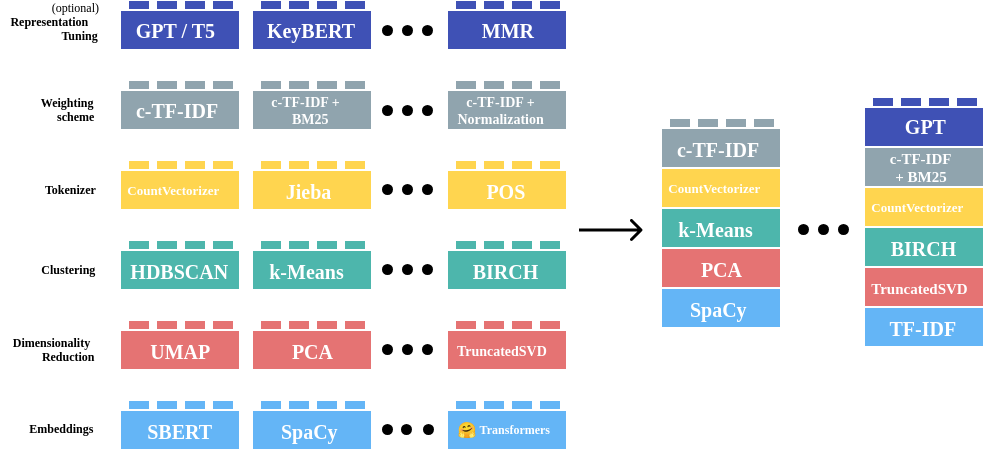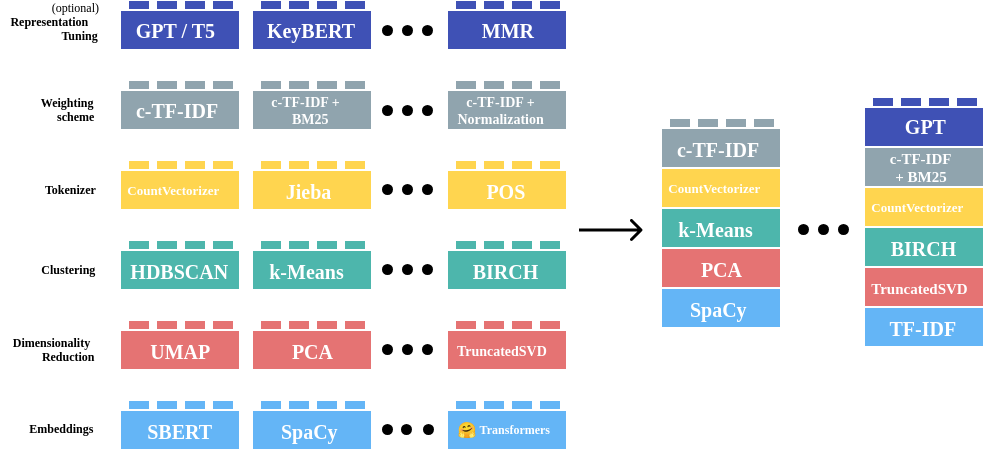

#### BERTopic is highly modular and customizible. I am going to perform experiments with the default architecture:
    - Sentence transformers are used for generating the embeddings
    - UMAP is used for dimensionality reduction
    - HDBSCAN is used to perform clustering
    - CountVectorizer used as a tokenizer
    - c-TF-IDF is used to identify the most important words within a topic

In [13]:
# sampling the data in the same way we did for LDA approach
sample_df = df['processed_complaint'].sample(frac=0.1, random_state=1996)

In [18]:
topic_model = BERTopic()

In [ ]:
%%time
topics, probs = topic_model.fit_transform(df['processed_complaint'])

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.visualize_topics()